# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
# Import python libraries and data
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import datetime
% matplotlib inline
import seaborn as sns

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [4]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [5]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


# Portfolio-Data Cleaning

In [6]:
available_channels = []

# Look to see what are all of the different channels
for channel in portfolio['channels']:
    for t in channel:
        if t not in available_channels:
            available_channels.append(t)
            
available_channels

['email', 'mobile', 'social', 'web']

In [7]:
# Add in the email, mobile, social, and web columns
for channel in available_channels:
    portfolio[channel] = portfolio['channels'].apply(lambda x: 1 if channel in x else 0)  

portfolio.drop('channels', axis = 1, inplace=True) # No longer need the channels column

# Make Sure all of the int and float columns are correct
cols_to_update = ['difficulty', 'duration','reward']

for col in cols_to_update:
    portfolio[col] = portfolio[col].apply(lambda x: int(x))


portfolio.head()

,difficulty,duration,id,offer_type,reward,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1


In [8]:
# Make sure that each row is unique
len(np.unique(portfolio['id'])) == len(portfolio)

True

In [9]:
portfolio.shape

(10, 9)

# Transcript Cleaning

In [10]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [11]:
transcript['value_type'] = transcript['value'].apply(lambda x: list(x.keys())[0]) # First value is the value_type
transcript['value'] = transcript['value'].apply(lambda x: list(x.values())[0]) # Second value is the new value

# Make sure that the time value is an integer amount
transcript['time'] = transcript['time'].apply(lambda x: int(x))

transcript.head()

,event,person,time,value,value_type
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer id
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer id
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,offer id
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,offer id
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,offer id


# Profile Cleaning

In [12]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [13]:
# For Gender, instead of assuming a gender, lets just make the gender Unknown
profile['gender'].fillna('U', inplace = True)
profile['income'] = profile['income'].apply(lambda x: float(x))
profile['age'] = profile['age'].apply(lambda x: int(x))

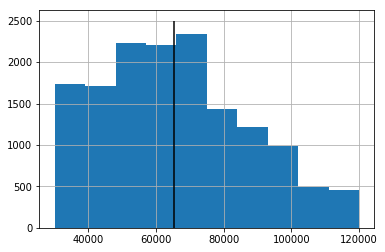

In [14]:
profile.income.hist(bins=10)
plt.vlines(profile.income.mean(),0,2500)

In [15]:
mean_val = profile.income.mean() # 65404.99
profile['income'].fillna(mean_val, inplace = True)

In [16]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,U,68be06ca386d4c31939f3a4f0e3dd783,65404.991568
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.000000
2,118,20180712,U,38fe809add3b4fcf9315a9694bb96ff5,65404.991568
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.000000
4,118,20170804,U,a03223e636434f42ac4c3df47e8bac43,65404.991568


In [17]:
# Converting became_member_on to an actual date number and also creating more
# columns based on the year, month, daay for further analysis
profile['member_year'] = profile.became_member_on.apply(lambda x: int(str(x)[:4]))
profile['member_month'] = profile.became_member_on.apply(lambda x: int(str(x)[4:6]))
profile['member_day'] = profile.became_member_on.apply(lambda x: int(str(x)[6:]))
profile['member_date'] = profile.became_member_on.apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
profile.drop('became_member_on', axis = 1, inplace = True)

# Exploratory Data analysis

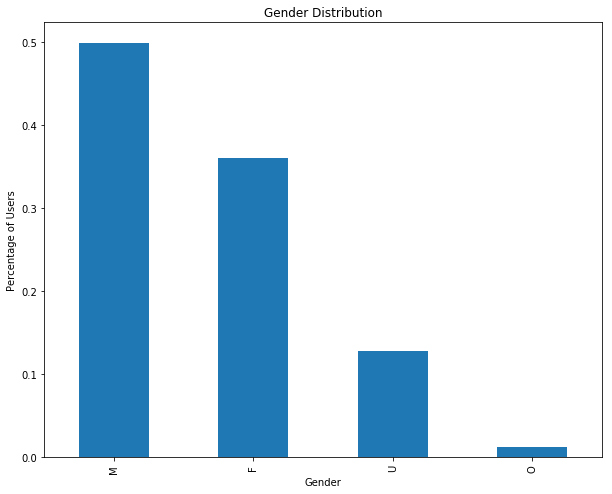

In [18]:
profile.gender.value_counts(normalize=True).plot('bar', figsize = (10,8))
plt.title('Gender Distribution')
plt.ylabel('Percentage of Users', fontsize = 10)
plt.xlabel('Gender', fontsize = 10);

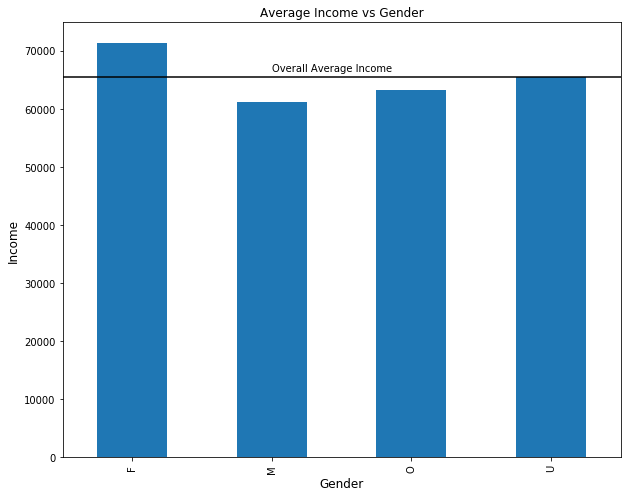

In [19]:
gender_income = profile.groupby('gender', as_index=False).agg({'income':'mean'})
gender_income.plot(kind = 'bar', x = 'gender', y = 'income', legend=False, figsize=(10,8))
plt.hlines(mean_val, -100 , 1000)
plt.ylabel('Income', fontsize = 12)
plt.xlabel('Gender', fontsize = 12)
plt.title('Average Income vs Gender')
plt.text(1, mean_val + 1000, 'Overall Average Income');

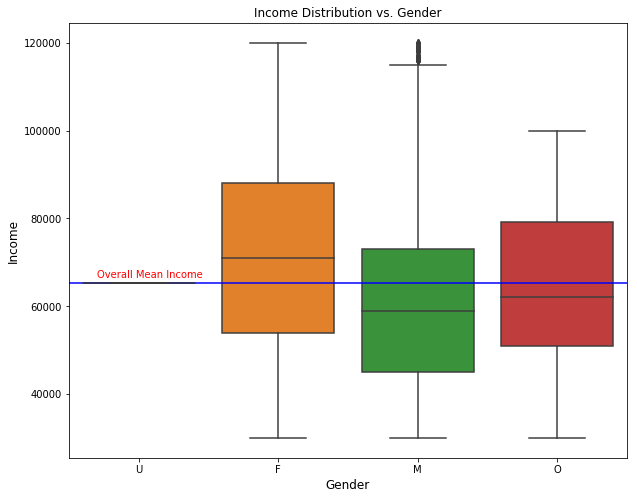

In [20]:
plt.figure(figsize=(10,8))
sns.boxplot(x = 'gender', y = 'income', data = profile)
plt.hlines(mean_val, -100 , 1000, color = 'b')
plt.ylabel('Income', fontsize = 12)
plt.xlabel('Gender', fontsize = 12)
plt.title('Income Distribution vs. Gender')
plt.text(x = -.3, y = mean_val + 1000, s = "Overall Mean Income", color = 'r');

# Customer Sign Ups
It is interesting to look at the days that customers signed up. You can see that there are 3 distinct points in time where there is a large increase in customer sign ups and then it seems to stay pretty consistent for a while after that. There was a significant decrease right around the start of 2018, which is an interesting point.

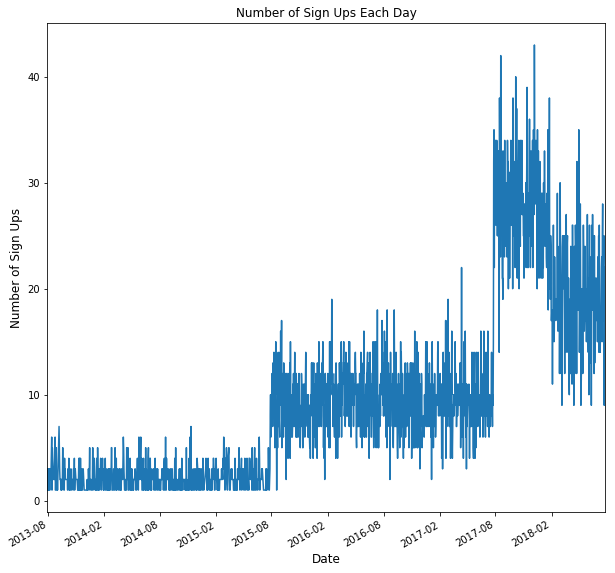

In [21]:
# Number of sign ups each day
profile.member_date.value_counts().plot(kind = 'line', figsize = (10,10))
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Number of Sign Ups', fontsize = 12)
plt.title('Number of Sign Ups Each Day');

We can also look at custoer subscriptions by month. It looks like in every year, subscriptions drop at the beginning of the year and then have a significant uprise right around July. 

One interesting thing to point is is that in even years, subsciptions seem to stay pretty constant, but in odd years, there are big jumps. Maybe there are new app releases in those years?

2018 also seems to be having a rough year. The summer months have had a big decrease in customer sign ups as opposes to the rate from previous years.

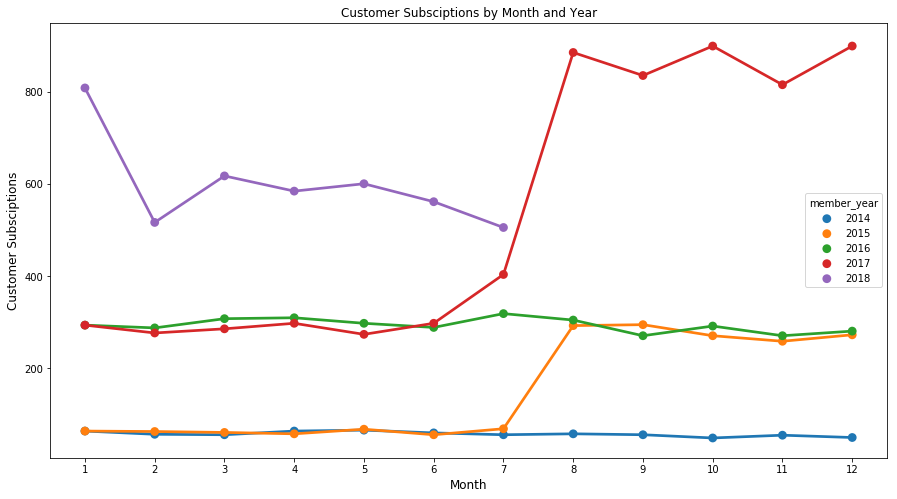

In [22]:
membership_subs = profile[profile['member_year'] >= 2014].groupby(['member_year','member_month'], as_index=False).agg({'id':'count'})
plt.figure(figsize=(15,8))
sns.pointplot(x="member_month", y="id", hue="member_year", data = membership_subs)
plt.ylabel('Customer Subsciptions', fontsize = 12)
plt.xlabel('Month', fontsize = 12)
plt.title('Customer Subsciptions by Month and Year');

# Customer Transaction

In [23]:
# This specific one is a discount offer that was recieved, viewed, and completed all on the same day
transcript[(transcript['person'] == '9fa9ae8f57894cc9a3b8a9bbe0fc1b2f') 
           & (transcript['value'] == '2906b810c7d4411798c6938adc9daaa5')]

,event,person,time,value,value_type
36,offer received,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,2906b810c7d4411798c6938adc9daaa5,offer id
12656,offer viewed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,2906b810c7d4411798c6938adc9daaa5,offer id
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,2906b810c7d4411798c6938adc9daaa5,offer_id


In [24]:
portfolio[portfolio['id'] == '2906b810c7d4411798c6938adc9daaa5']

,difficulty,duration,id,offer_type,reward,email,mobile,social,web
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1


In [25]:
# The different events that come through are mostly transactions, then apropriately the offers recieved, 
# offers viewed, and offers completed.
transcript['event'].value_counts(normalize = True)

transaction        0.453304
offer received     0.248837
offer viewed       0.188315
offer completed    0.109544
Name: event, dtype: float64

In [26]:
# Looking at all of the completed offers, discounts and bogos are roughly a 50/50 split. 
trans_and_offers = pd.merge(transcript[(transcript['value_type'] == 'offer_id') & (transcript['event'] == 'offer completed')]
                            , portfolio, how = 'inner', left_on = 'value', right_on = 'id')
trans_and_offers['offer_type'].value_counts(normalize = True)

discount    0.533369
bogo        0.466631
Name: offer_type, dtype: float64

In [27]:
transcript.head()

,event,person,time,value,value_type
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer id
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer id
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,offer id
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,offer id
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,offer id


In [28]:
portfolio.head()

,difficulty,duration,id,offer_type,reward,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1


In [29]:
trans_and_offers.head()

,event,person,time,value,value_type,difficulty,duration,id,offer_type,reward,email,mobile,social,web
0,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,2906b810c7d4411798c6938adc9daaa5,offer_id,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1
1,offer completed,73ffefd41e9a4ca3ab26b2b3697c6eb7,0,2906b810c7d4411798c6938adc9daaa5,offer_id,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1
2,offer completed,24115a61df25473e84a8a03f3c98de1a,0,2906b810c7d4411798c6938adc9daaa5,offer_id,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1
3,offer completed,2481f1fcfbcb4b288e5a03af02d95373,0,2906b810c7d4411798c6938adc9daaa5,offer_id,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1
4,offer completed,a45b69f1c8554ae7af83e74426ca437a,0,2906b810c7d4411798c6938adc9daaa5,offer_id,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1


# Data Analysis

## Offer Type Analysis¶

First, let's just look at one person's transaction amounts. We can get the average value amount and days between purchases.

In [30]:
# All amount transactions of a random person
test_person_transactions = transcript[(transcript['person'] == '8dbfa485249f409aa223a2130f40634a')
          & (transcript['value_type'] == 'amount')].reset_index()
# Get the difference of days between purchases
test_person_transactions['DaysFromLastPurchase'] = test_person_transactions.time.diff()

# The first value needs to be the same as the first transaction time inseat of NULL
test_person_transactions.iloc[0, -1] = test_person_transactions.loc[0, 'time']

# Need to set values as an float

test_person_transactions['value'] = test_person_transactions['value'].apply(lambda x: float(x))

# Don't need the reset index column anymore
test_person_transactions.drop('index', axis = 1, inplace = True)
test_person_transactions.head(10)

,event,person,time,value,value_type,DaysFromLastPurchase
0,transaction,8dbfa485249f409aa223a2130f40634a,6,3.86,amount,6.0
1,transaction,8dbfa485249f409aa223a2130f40634a,30,0.88,amount,24.0
2,transaction,8dbfa485249f409aa223a2130f40634a,36,2.86,amount,6.0
3,transaction,8dbfa485249f409aa223a2130f40634a,54,0.17,amount,18.0
4,transaction,8dbfa485249f409aa223a2130f40634a,78,1.02,amount,24.0
5,transaction,8dbfa485249f409aa223a2130f40634a,84,0.49,amount,6.0
6,transaction,8dbfa485249f409aa223a2130f40634a,108,1.72,amount,24.0
7,transaction,8dbfa485249f409aa223a2130f40634a,186,1.66,amount,78.0
8,transaction,8dbfa485249f409aa223a2130f40634a,192,0.61,amount,6.0
9,transaction,8dbfa485249f409aa223a2130f40634a,228,1.31,amount,36.0


In [31]:
# Now we can aggregate the values to get the average transaction amount, average days between purchases,
# and how long that they have been a customer
test_person_transactions.groupby('person')\
.agg({
'value':'mean' #Average transaction Amount
,'DaysFromLastPurchase':'mean' #Average days between purchases
,'time':'max' # How long they have been a Starbucks member
})

,value,DaysFromLastPurchase,time
person,,,
8dbfa485249f409aa223a2130f40634a,2.123889,18.833333,678


# Promotion activity
What about how customers react with different promotions? What we would want to see is what promotions the customer recieved and which ones he completed for that specific promotion type

In [32]:
# Want to look at recieved transactions and completed transactions
test_completion = pd.merge(
                    transcript[transcript['event'] == 'offer received']
                    , transcript[transcript['event'] == 'offer completed']
                    , how = 'left'
                    , left_on = ['person','value']
                    , right_on = ['person','value']
        )

# Make sure that the time values are converted to floats / integers
test_completion['time_y'] = test_completion['time_y'].apply(lambda x: float(x))
test_completion['time_x'] = test_completion['time_x'].apply(lambda x: float(x))

In [33]:
completion = test_completion[
    (
        (test_completion['time_y'] <= (test_completion['time_x'] + 20)) # Completion date is within max time frame
        & (test_completion['time_y'] >= test_completion['time_x'])  # Completion date is after offer received
    )
    
    | # or 
    
    (pd.isnull(test_completion['event_y']) == True) # Null values to show offers that were never completed
        ][['person','time_x','value','event_y','time_y']]

completion['DaysToCompleteOffer'] = completion['time_y'] - completion['time_x'] 
completion['CompletedOffer'] = completion['event_y'].apply(lambda x: 0 if pd.isnull(x) == True else 1)
completion.tail()

,person,time_x,value,event_y,time_y,DaysToCompleteOffer,CompletedOffer
86425,f924927e7f844ecebf87eef93f4d2688,576.0,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,NaN,0
86426,a57890c3bbb7463e9018abb7fecadb15,576.0,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,NaN,0
86429,6d5f3a774f3d4714ab0c092238f3a1d7,576.0,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN,NaN,0
86430,9dc1421481194dcd9400aec7c9ae6366,576.0,ae264e3637204a6fb9bb56bc8210ddfd,offer completed,594.0,18.0,1
86431,e4052622e5ba45a8b96b59aba68cf068,576.0,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN,0


In [34]:
completion[completion['person'] == '8dbfa485249f409aa223a2130f40634a']

,person,time_x,value,event_y,time_y,DaysToCompleteOffer,CompletedOffer
5765,8dbfa485249f409aa223a2130f40634a,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN,0
63399,8dbfa485249f409aa223a2130f40634a,504.0,ae264e3637204a6fb9bb56bc8210ddfd,NaN,NaN,NaN,0


In [35]:
completion[completion['person'] == '9dc1421481194dcd9400aec7c9ae6366']

,person,time_x,value,event_y,time_y,DaysToCompleteOffer,CompletedOffer
57550,9dc1421481194dcd9400aec7c9ae6366,408.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer completed,414.0,6.0,1
86430,9dc1421481194dcd9400aec7c9ae6366,576.0,ae264e3637204a6fb9bb56bc8210ddfd,offer completed,594.0,18.0,1


In [36]:
completion[completion['person'] == '9dc1421481194dcd9400aec7c9ae6366'].groupby('person').agg({
    
    'time_x':'min' # When they recieved their first offer
    , 'CompletedOffer': 'mean' # Percentage of Completed Offers
    , 'DaysToCompleteOffer': 'mean' # Average time it takes to complete an offer
})

,time_x,CompletedOffer,DaysToCompleteOffer
person,,,
9dc1421481194dcd9400aec7c9ae6366,408.0,1,12.0


# Does the type of offer determine if  someone will complete it and how long it will take to complete?
Since we have the offers that people received and whether they completed it or not, we can now see if there is a trend with what offers are being completed the most and other statistics about it

In [37]:
# Bring together the completed / non completed offers and what type of offer they were
offers_final_df = pd.merge(completion
         ,portfolio
         , how = 'inner'
         , left_on = 'value'
         , right_on = 'id'
        )[['person','time_x','value','CompletedOffer','DaysToCompleteOffer'
          , 'difficulty','duration','offer_type','reward','email','mobile','social','web'
          ]]
offers_final_df.columns = ['person','offer_time','value','CompletedOffer','DaysToCompleteOffer'
                          ,'difficulty','duration','offer_type','reward'
                          , 'email','mobile','social','web'
                        ]
offers_final_df['NetReward'] = offers_final_df['reward'] - offers_final_df['difficulty']
offers_final_df.tail()

,person,offer_time,value,CompletedOffer,DaysToCompleteOffer,difficulty,duration,offer_type,reward,email,mobile,social,web,NetReward
48845,db1805ed333844978e8b46ed3e4643ae,576.0,f19421c1d4aa40978ebb69ca19b0e20d,0,NaN,5,5,bogo,5,1,1,1,1,0
48846,eec70ab28af74a22a4aeb889c0317944,576.0,f19421c1d4aa40978ebb69ca19b0e20d,1,18.0,5,5,bogo,5,1,1,1,1,0
48847,31e915c24163436790b97c1d45b545f6,576.0,f19421c1d4aa40978ebb69ca19b0e20d,1,18.0,5,5,bogo,5,1,1,1,1,0
48848,361539b15a6243dc834c6b25e481570b,576.0,f19421c1d4aa40978ebb69ca19b0e20d,0,NaN,5,5,bogo,5,1,1,1,1,0
48849,eb7dd979f4644052a5c401a01f129132,576.0,f19421c1d4aa40978ebb69ca19b0e20d,0,NaN,5,5,bogo,5,1,1,1,1,0


In [38]:
offers_final_df.head(10)

,person,offer_time,value,CompletedOffer,DaysToCompleteOffer,difficulty,duration,offer_type,reward,email,mobile,social,web,NetReward
0,a03223e636434f42ac4c3df47e8bac43,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,NaN,20,10,discount,5,1,0,0,1,-15
1,aa4862eba776480b8bb9c68455b8c2e1,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,NaN,20,10,discount,5,1,0,0,1,-15
2,31dda685af34476cad5bc968bdb01c53,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,NaN,20,10,discount,5,1,0,0,1,-15
3,744d603ef08c4f33af5a61c8c7628d1c,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,NaN,20,10,discount,5,1,0,0,1,-15
4,3d02345581554e81b7b289ab5e288078,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,NaN,20,10,discount,5,1,0,0,1,-15
5,3f4e408b0b2d4ea89dd16d7437d867c1,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,NaN,20,10,discount,5,1,0,0,1,-15
6,23f9e3baf42b43148fee9bbbc3530c7a,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,NaN,20,10,discount,5,1,0,0,1,-15
7,5f18c5754dc04baaa1267c823f877a85,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,NaN,20,10,discount,5,1,0,0,1,-15
8,21b02228cd4441b49bf0b5ff046f4b75,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,NaN,20,10,discount,5,1,0,0,1,-15
9,e94a9c2e750645d0a1aca57a9b4ca4c3,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,NaN,20,10,discount,5,1,0,0,1,-15


We can see that the lower the difficulty, the more likely someone is going to complete the reward. The informational offer type means nothing in this section, it will be helpful for looking at other individual statistics for individuals.



In [39]:
offers_final_df[offers_final_df['offer_type']=='bogo']

,person,offer_time,value,CompletedOffer,DaysToCompleteOffer,difficulty,duration,offer_type,reward,email,mobile,social,web,NetReward
11735,68617ca6246f4fbc85e91a2a49552598,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,NaN,10,5,bogo,10,1,1,1,1,0
11736,102e9454054946fda62242d2e176fdce,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,1,6.0,10,5,bogo,10,1,1,1,1,0
11737,7584948ea6d04f94b8798624706261c2,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,NaN,10,5,bogo,10,1,1,1,1,0
11738,e8fe7ffcf1634713a819d48447737c90,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,NaN,10,5,bogo,10,1,1,1,1,0
11739,b19c8e7ac2ff40ae92b4fcf3247f8912,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,NaN,10,5,bogo,10,1,1,1,1,0
11740,f35b342b24734da18a830bb9329a4fbd,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,NaN,10,5,bogo,10,1,1,1,1,0
11741,30fae86966114f6e83c3043b22b6b7c4,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,NaN,10,5,bogo,10,1,1,1,1,0
11742,2ce2e03319c7446ca9c379b4589da19b,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,NaN,10,5,bogo,10,1,1,1,1,0
11743,02f77bb76ed14d28a05e23b3e00aeb9b,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,NaN,10,5,bogo,10,1,1,1,1,0
11744,e08a264dc9a54efca07e1cf7e9b38480,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,NaN,10,5,bogo,10,1,1,1,1,0


In [40]:
offers_final_df['offer_type'].value_counts()

bogo             18332
discount         15283
informational    15235
Name: offer_type, dtype: int64

In [41]:
offers_final_df[offers_final_df['offer_type']=='discount']

,person,offer_time,value,CompletedOffer,DaysToCompleteOffer,difficulty,duration,offer_type,reward,email,mobile,social,web,NetReward
0,a03223e636434f42ac4c3df47e8bac43,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,NaN,20,10,discount,5,1,0,0,1,-15
1,aa4862eba776480b8bb9c68455b8c2e1,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,NaN,20,10,discount,5,1,0,0,1,-15
2,31dda685af34476cad5bc968bdb01c53,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,NaN,20,10,discount,5,1,0,0,1,-15
3,744d603ef08c4f33af5a61c8c7628d1c,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,NaN,20,10,discount,5,1,0,0,1,-15
4,3d02345581554e81b7b289ab5e288078,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,NaN,20,10,discount,5,1,0,0,1,-15
5,3f4e408b0b2d4ea89dd16d7437d867c1,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,NaN,20,10,discount,5,1,0,0,1,-15
6,23f9e3baf42b43148fee9bbbc3530c7a,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,NaN,20,10,discount,5,1,0,0,1,-15
7,5f18c5754dc04baaa1267c823f877a85,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,NaN,20,10,discount,5,1,0,0,1,-15
8,21b02228cd4441b49bf0b5ff046f4b75,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,NaN,20,10,discount,5,1,0,0,1,-15
9,e94a9c2e750645d0a1aca57a9b4ca4c3,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,NaN,20,10,discount,5,1,0,0,1,-15


In [42]:
offers_final_df[offers_final_df['offer_type']=='informational']

,person,offer_time,value,CompletedOffer,DaysToCompleteOffer,difficulty,duration,offer_type,reward,email,mobile,social,web,NetReward
20416,2eeac8d8feae4a8cad5a6af0499a211d,0.0,3f207df678b143eea3cee63160fa8bed,0,NaN,0,4,informational,0,1,1,0,1,0
20417,c27e0d6ab72c455a8bb66d980963de60,0.0,3f207df678b143eea3cee63160fa8bed,0,NaN,0,4,informational,0,1,1,0,1,0
20418,2c5c63e5124e417b8504f76c868a4190,0.0,3f207df678b143eea3cee63160fa8bed,0,NaN,0,4,informational,0,1,1,0,1,0
20419,5e9c83e8ab4d4e9ca83f3256d83ca756,0.0,3f207df678b143eea3cee63160fa8bed,0,NaN,0,4,informational,0,1,1,0,1,0
20420,6747dda08bed46298c23e05b64820a3a,0.0,3f207df678b143eea3cee63160fa8bed,0,NaN,0,4,informational,0,1,1,0,1,0
20421,37a97f6e09784a07bbb67bc6539f1a00,0.0,3f207df678b143eea3cee63160fa8bed,0,NaN,0,4,informational,0,1,1,0,1,0
20422,65f06566a2a14f64b003964f211635e1,0.0,3f207df678b143eea3cee63160fa8bed,0,NaN,0,4,informational,0,1,1,0,1,0
20423,0f54094029ca4107bfd36203aeb3ed14,0.0,3f207df678b143eea3cee63160fa8bed,0,NaN,0,4,informational,0,1,1,0,1,0
20424,fd700397b7c8440baa70d5539926c5a0,0.0,3f207df678b143eea3cee63160fa8bed,0,NaN,0,4,informational,0,1,1,0,1,0
20425,3ecb372184104ff7bad0f0f60cb56e29,0.0,3f207df678b143eea3cee63160fa8bed,0,NaN,0,4,informational,0,1,1,0,1,0


In [43]:
overall_offers_df = offers_final_df.groupby(['offer_type','difficulty','reward'], as_index = False).agg({
    'CompletedOffer':['mean', 'sum'] # Average of time they complete the order
    , 'DaysToCompleteOffer':'mean' # Average days it takes for someone to complete the order
    , 'NetReward': 'max' # The net reward (should be just the reward - difficulty)
})

overall_offers_df.columns.droplevel(1)
overall_offers_df.columns = ['offer_type','difficulty','reward','CompletedOffers','TotalCompletions'
                            , 'AvgDaysToComplete','NetReward']
overall_offers_df['NetWorth'] = (overall_offers_df['CompletedOffers'] * overall_offers_df['NetReward']) * -1
final_overall_offers_df = overall_offers_df[overall_offers_df['offer_type'] != 'informational']
final_overall_offers_df

,offer_type,difficulty,reward,CompletedOffers,TotalCompletions,AvgDaysToComplete,NetReward,NetWorth
0,bogo,5,5,0.308293,2606,8.638526,0,-0.000000
1,bogo,10,10,0.217532,2149,9.001396,0,-0.000000
2,discount,7,3,0.383878,1362,8.938326,-4,1.535513
3,discount,10,2,0.279512,2060,8.906796,-8,2.236092
4,discount,20,5,0.090034,393,9.511450,-15,1.350515


Looking at the discounts, you can see that even though the net reward is better for Starbucks, it doesn't necessarily mean that they will make the most expected money. The NetWorth column shows how much Starbucks makes from that offer by multiplying the probability of someone actually using that coupon shows that the best coupon is 2 dollar if you spend 10 dollar. That will get an expected reward back of 2.23, while the other offers make roughly 1.50

# Individual metrics
To get our clusters together, we now need to bring all of the above metrics at an individual level.

In [44]:

all_transactions = transcript[transcript['value_type'] == 'amount']
all_transactions['value'] = all_transactions['value'].apply(lambda x: float(x))
all_transactions.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,event,person,time,value,value_type
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,0.83,amount
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,amount
12659,transaction,54890f68699049c2a04d415abc25e717,0,13.23,amount
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51,amount
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,18.97,amount


In [45]:
df_all_customers = pd.DataFrame(columns = ['person', 'discount_total_offers', 'discount_completion_pct',
       'discount_min_completion_days', 'discount_max_completion_days', 'discount_completed_offers',
       'discount_avg_completion_days', 'discount_avg_net_reward',
       'bogo_total_offers', 'bogo_completion_pct', 'bogo_completed_offers' 'bogo_min_completion_days',
       'bogo_max_completion_days', 'bogo_avg_completion_days',
       'bogo_avg_net_reward', 'informational_promotions', 'age', 'gender',
       'income', 'member_date', 'total_transactions', 'min_transaction_day',
       'max_transaction_day', 'avg_transaction', 'total_transaction_amount',
       'median_days_between_purchases', 'avg_days_between_purchases'])

for person in np.unique(profile['id']):
    
    # Get Individual profile info
    personal_profile = profile[profile['id'] == person][['id','age','gender','income','member_date']]
    
    # Get transaction aggregates
    personal_transactions = all_transactions[all_transactions['person'] == person].reset_index()
    if len(personal_transactions) > 0:
        personal_transactions['DaysFromLastPurchase'] = personal_transactions.time.diff()
        personal_transactions.iloc[0, -1] = test_person_transactions.loc[0, 'time']

        personal_agg_trans = personal_transactions.groupby('person', as_index = False).agg(
        {
            'time': ['count','min','max'] # First and Last Purchase
            , 'value': ['mean', 'sum'] # Average Purchase Amount, total purchase amount
            , 'DaysFromLastPurchase': ['median', 'mean'] # Average days between purchases  
        })
        personal_agg_trans.columns = personal_agg_trans.columns.droplevel(1) # Gets rid of the multi leveling columns
        personal_agg_trans.columns = ['person', 'total_transactions','min_transaction_day','max_transaction_day'
                                      , 'avg_transaction','total_transaction_amount','median_days_between_purchases'
                                      ,'avg_days_between_purchases']
    else:
        null_array = [person, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
        personal_agg_trans = pd.DataFrame([null_array]
                                         , columns = ['person', 'total_transactions','min_transaction_day'
                                                      ,'max_transaction_day'
                                                      , 'avg_transaction','median_days_between_purchases'
                                                      ,'avg_days_between_purchases'])
        
        
    # Bring together the transaction aggregates and the profile values
    personal_df_1 = pd.merge(personal_profile, personal_agg_trans
                             , how = 'inner', left_on = 'id', right_on = 'person')
    personal_df_1.drop('id', axis = 1, inplace = True) # Get rid of the ID column
    
    
    # Look at the different promotions that the person interacted with
    # Using global variables to join data in the next step
    for offer_type in ['discount','bogo']:
        globals()[offer_type + '_df'] =  offers_final_df[(offers_final_df['person'] == person)
                       & (offers_final_df['offer_type'] == offer_type)
                       ].groupby('person', as_index = False).agg({
                                                        'CompletedOffer':['count','mean','sum']
                                                        , 'DaysToCompleteOffer': ['min','max','mean']
                                                        , 'NetReward': ['mean']
                                                    })
        
        globals()[offer_type + '_df'].columns = globals()[offer_type + '_df'].columns.droplevel(1)
        globals()[offer_type + '_df'].columns = ['person', offer_type + '_total_offers'
                                    ,offer_type + '_completion_pct', offer_type + '_completed_offers'
                                   , offer_type + '_min_completion_days',offer_type + '_max_completion_days'
                                    ,offer_type + '_avg_completion_days', offer_type + '_avg_net_reward']
        
        if len(globals()[offer_type + '_df']) == 0:
            null_array = [person,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan, np.nan]
            globals()[offer_type + '_df'] = globals()[offer_type + '_df'].append(
                dict(zip(globals()[offer_type + '_df'].columns, null_array)), ignore_index=True
            )
    
    # Bring together the bogo and discount values, and include the number of informational promos they received
    bogo_and_discounts = pd.merge(discount_df, bogo_df)
    bogo_and_discounts['informational_promotions'] = len(offers_final_df[(offers_final_df['person'] == person)
                                                               & (offers_final_df['offer_type'] == 'informational')])
    
    # Bring everything together
    person_final = pd.merge(bogo_and_discounts, personal_df_1)
    
    # Add personal df to the rest of the customer dataframe
    df_all_customers = df_all_customers.append(person_final)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [46]:
len(df_all_customers) == len(profile)

True

In [48]:
df_all_customers.head(10)

,person,discount_total_offers,discount_completion_pct,discount_min_completion_days,discount_max_completion_days,discount_completed_offers,discount_avg_completion_days,discount_avg_net_reward,bogo_total_offers,bogo_completion_pct,...,gender,income,member_date,total_transactions,min_transaction_day,max_transaction_day,avg_transaction,total_transaction_amount,median_days_between_purchases,avg_days_between_purchases
0,0009655768c64bdeb2e877511632db8f,1,1,0.0,0.0,1,0.0,-8,1,1,...,M,72000.000000,2017-04-21,8,228,696,15.950000,127.60,27.0,59.250000
0,00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0,...,U,65404.991568,2018-04-25,3,294,474,1.363333,4.09,18.0,62.000000
0,0011e0d4e6b944f998e987f904e8c1e5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,O,57000.000000,2018-01-09,5,132,654,15.892000,79.46,66.0,105.600000
0,0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,...,F,90000.000000,2016-03-04,8,54,708,24.607500,196.86,21.0,82.500000
0,0020ccbbb6d84e358d3414a3ff76cffd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,F,60000.000000,2016-11-11,12,42,672,12.837500,154.05,30.0,53.000000
0,003d66b6608740288d6cc97a6903f4f0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,F,73000.000000,2017-06-21,18,66,696,2.685556,48.34,21.0,35.333333
0,00426fe3ffde4c6b9cb9ad6d077a13ea,3,0,NaN,NaN,0,NaN,-10.3333,NaN,NaN,...,F,65000.000000,2016-08-09,17,36,696,4.030000,68.51,18.0,39.176471
0,004b041fbfe44859945daa2c7f79ee64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,F,74000.000000,2018-05-08,6,18,714,23.060000,138.36,90.0,117.000000
0,004c5799adbf42868b9cff0396190900,1,1,0.0,0.0,1,0.0,-8,1,1,...,M,99000.000000,2016-03-31,12,222,690,28.948333,347.38,27.0,39.500000
0,005500a7188546ff8a767329a2f7c76a,1,0,NaN,NaN,0,NaN,-8,3,0,...,M,47000.000000,2017-12-09,4,204,588,5.090000,20.36,33.0,97.500000


In [50]:
# Just to get the columns in the order that I would like
df_all_customers = df_all_customers[['person', 'discount_total_offers', 'discount_completion_pct',
       'discount_min_completion_days', 'discount_max_completion_days', 'discount_completed_offers',
       'discount_avg_completion_days', 'discount_avg_net_reward',
       'bogo_total_offers', 'bogo_completion_pct', 'bogo_completed_offers' 'bogo_min_completion_days',
       'bogo_max_completion_days', 'bogo_avg_completion_days',
       'bogo_avg_net_reward', 'informational_promotions', 'age', 'gender',
       'income', 'member_date', 'total_transactions', 'min_transaction_day',
       'max_transaction_day', 'avg_transaction', 'total_transaction_amount',
       'median_days_between_purchases', 'avg_days_between_purchases']]

# Final Analysis
Now that we have each customer in a dataframe with all of their personal characteristics, transactional aggregates, and promotional aggregates, one way that we can improve on correct promotional affiliation is to see how that specific cluster responds to different promotions.

We want to take all of the attributes that can be used to cluster customers and fill their null values with 0's because those columns show that the customer didn't participate in that category. We also need to make gender a dummy vairable since it is the only true categorical variable.

I decided to use the AgglomerativeClustering clustering algorithm because it tries to minimize the clustering distance from each other, and the ward linkage paramter minimizes the variance of the clusters being merged, which I belive is the best option as opposed to finding the average distance from each cluster center.

I used 4 clusters because you can ideally fall into 4 different types of peole who react to promotions:

Use both BOGO and Discounts
Dont use either BOGO or Discounts
Favor BOGO over Discount
Favor Discount over BOGO

In [51]:
from sklearn import cluster
from sklearn.cluster import KMeans

In [52]:
X = df_all_customers[['discount_total_offers', 'discount_completion_pct',
       'discount_min_completion_days', 'discount_max_completion_days', 'discount_completed_offers',
       'discount_avg_completion_days', 'discount_avg_net_reward',
       'bogo_total_offers', 'bogo_completion_pct', 'bogo_completed_offers' 'bogo_min_completion_days',
       'bogo_max_completion_days', 'bogo_avg_completion_days',
       'bogo_avg_net_reward', 'informational_promotions', 'age', 'gender',
       'income', 'total_transactions', 'min_transaction_day',
       'max_transaction_day', 'avg_transaction', 'total_transaction_amount',
       'median_days_between_purchases', 'avg_days_between_purchases']].fillna(0)

# Gender is the only true categorical variable, so we need to make a dummy value for it
new_x = pd.get_dummies(data=X, columns=['gender'])

We want to see what a good number of clusters would be to analyze. Below we are going to use the sum of squared values of the points from the center of their cluster. The more the clusters, the lower the value will be, so we want to look for where there stops being significant drops in the SSE. This is also known as the Elbow Method

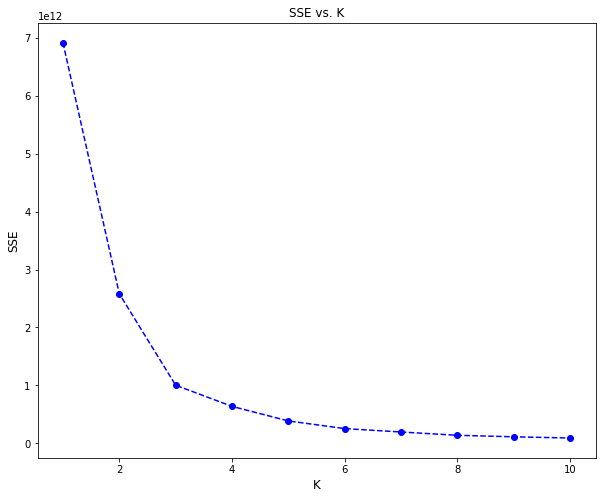

In [53]:
scores = []

for k in range(1,11):
    kmeans = KMeans(k)
    
    model = kmeans.fit(new_x)
    
    scores.append(abs(model.score(new_x)))
    
plt.figure(figsize=(10,8))
plt.plot(range(1,11), scores, linestyle='--', marker='o', color='b');
plt.xlabel('K', fontsize = 12);
plt.ylabel('SSE', fontsize = 12);
plt.title('SSE vs. K', fontsize = 12);

In [54]:
# Taking 4 clusters since that is the best value from the elbow method chart above
clust = cluster.AgglomerativeClustering(4, linkage='ward')

# Want to create new dataframe that only takes the features that should be examined. The only feature that would be
# useless to include would be the person ID
# We also want to fill any values that are NULl with 0. This is apropriate because the values that could be NULL
# is if the customer never participated in it

X = df_all_customers[['discount_total_offers', 'discount_completion_pct',
       'discount_min_completion_days', 'discount_max_completion_days', 'discount_completed_offers',
       'discount_avg_completion_days', 'discount_avg_net_reward',
       'bogo_total_offers', 'bogo_completion_pct', 'bogo_completed_offers' 'bogo_min_completion_days',
       'bogo_max_completion_days', 'bogo_avg_completion_days',
       'bogo_avg_net_reward', 'informational_promotions', 'age', 'gender',
       'income', 'total_transactions', 'min_transaction_day',
       'max_transaction_day', 'avg_transaction', 'total_transaction_amount',
       'median_days_between_purchases', 'avg_days_between_purchases']].fillna(0)

# Gender is the only true categorical variable, so we need to make a dummy value for it
new_x = pd.get_dummies(data=X, columns=['gender'])

# Set the Cluster 4 column with the cluster predictions of the clustering algorithm
df_all_customers['Cluster_4'] = clust.fit_predict(new_x)

In [55]:

df_all_customers.head()

,person,discount_total_offers,discount_completion_pct,discount_min_completion_days,discount_max_completion_days,discount_completed_offers,discount_avg_completion_days,discount_avg_net_reward,bogo_total_offers,bogo_completion_pct,...,income,member_date,total_transactions,min_transaction_day,max_transaction_day,avg_transaction,total_transaction_amount,median_days_between_purchases,avg_days_between_purchases,Cluster_4
0,0009655768c64bdeb2e877511632db8f,1,1,0.0,0.0,1,0.0,-8,1,1,...,72000.000000,2017-04-21,8,228,696,15.950000,127.60,27.0,59.25,2
0,00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0,...,65404.991568,2018-04-25,3,294,474,1.363333,4.09,18.0,62.00,2
0,0011e0d4e6b944f998e987f904e8c1e5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,57000.000000,2018-01-09,5,132,654,15.892000,79.46,66.0,105.60,1
0,0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,...,90000.000000,2016-03-04,8,54,708,24.607500,196.86,21.0,82.50,0
0,0020ccbbb6d84e358d3414a3ff76cffd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,60000.000000,2016-11-11,12,42,672,12.837500,154.05,30.0,53.00,1


Now that we have associated a cluster to each person, let's see what the breakdown of these clusters are and what key attributes each cluster shows

In [56]:
df_all_customers.Cluster_4.value_counts(normalize = True)

2    0.334941
1    0.260647
0    0.256176
3    0.148235
Name: Cluster_4, dtype: float64

We should first looka at a seaborn pairplot to look at distributions of each cluster and how they cross compare to other features. This first graph looks at more personal attributes like age, gender, income, and avg transaction amount

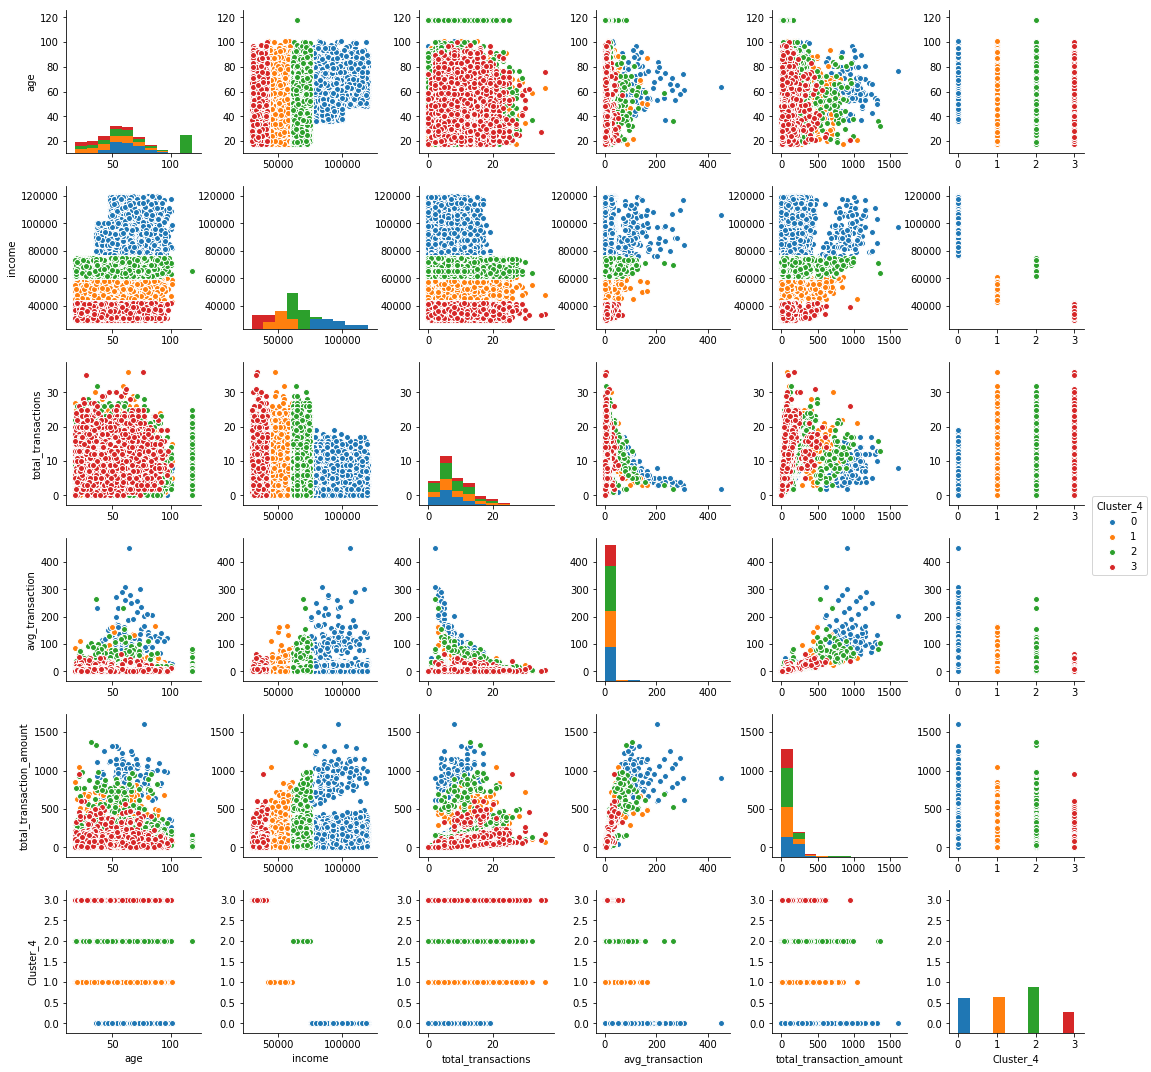

In [57]:
# Personal Demographics
visual_columns = ['age'
                  , 'gender'
                  ,'income'
                  , 'total_transactions'
                  , 'avg_transaction'
                  , 'total_transaction_amount'
                  ,'Cluster_4']

sns_personal_attributes = sns.pairplot(df_all_customers[visual_columns].fillna(0), hue='Cluster_4');
sns_personal_attributes.savefig("personal_attributes_clusters.png")

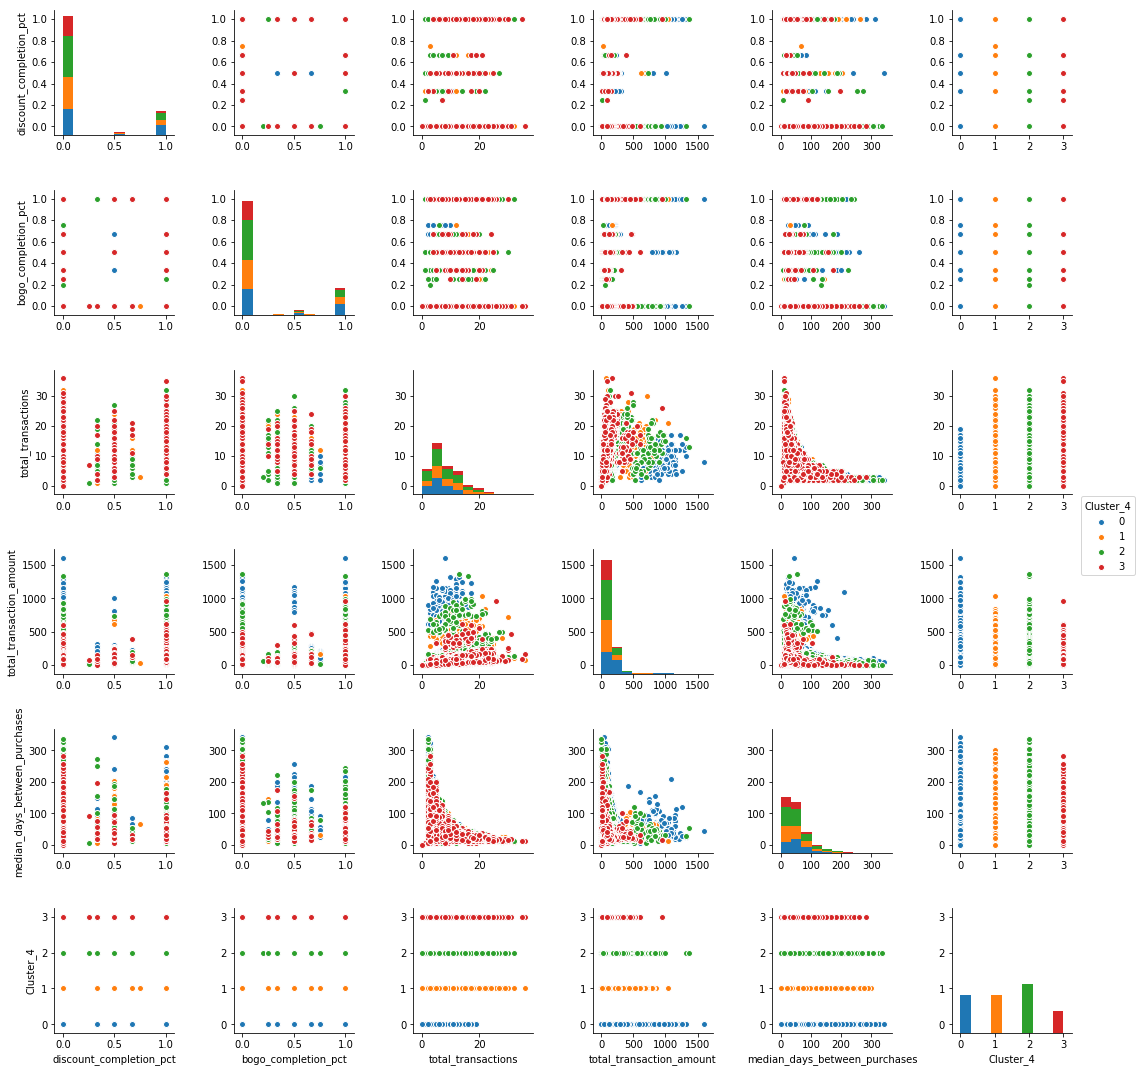

In [58]:
visual_columns = ['discount_completion_pct','bogo_completion_pct',
        'total_transactions', 'total_transaction_amount',
       'median_days_between_purchases','Cluster_4']

seaborn_trans_info = sns.pairplot(df_all_customers[visual_columns].fillna(0), hue='Cluster_4')
seaborn_trans_info.savefig("personal_transactions_clusters.png")

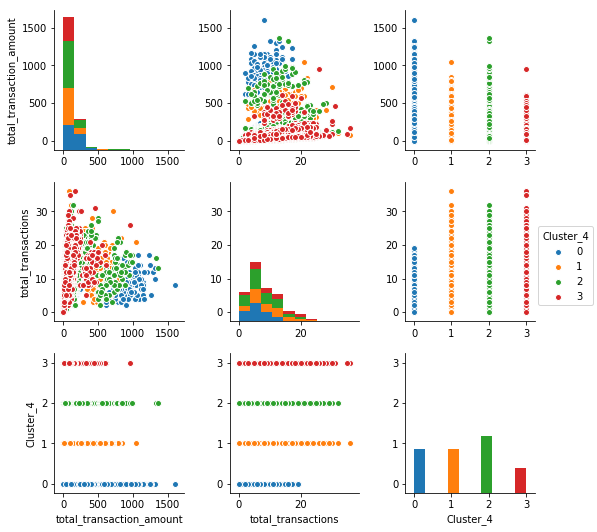

In [59]:
plt.figure(figsize= (10,8))
sns.pairplot(df_all_customers[['total_transaction_amount','total_transactions','Cluster_4']].fillna(0), hue='Cluster_4');

Looking at total transactions vs total transction amounts, we see that Cluster 0 spends a lot more money than the other clusters, but don't go as often as Cluster 3. Cluster 3 looks like they go more frequently, but don't spend a lot of money overall. Cluster 2, which had the largest population, has a wide variance in this category, they don't really fit into a specific slot.

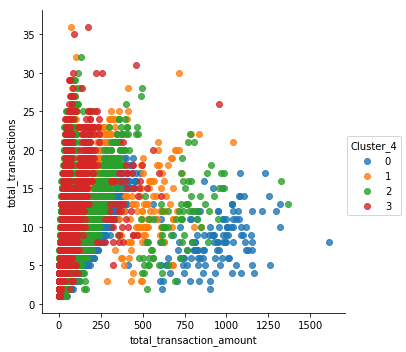

In [60]:
plt.figure(figsize = (20,10))
sns.lmplot(x='total_transaction_amount', y='total_transactions', hue='Cluster_4'
           , data=df_all_customers, fit_reg=False);

When looking at the total nuber of transactions and the freqency of the customer going to Starbucks shops, it looks like all distributions follow the same pattern. The people who come more freqently spend more money and the people who don't come as frequent spend less.

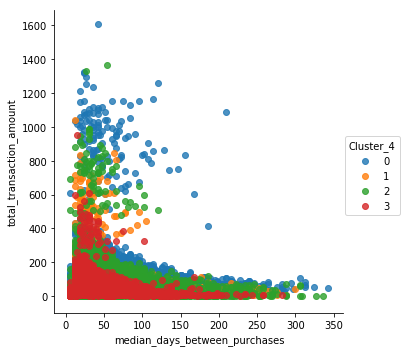

In [61]:
plt.figure(figsize = (20,20));
sns.lmplot(x='median_days_between_purchases', y='total_transaction_amount', hue='Cluster_4'
           , data=df_all_customers, fit_reg=False);

Income has the biggest explanation of the different clusters. As we can see, each cluster has a specific range of income that they make, which in turn would have a big impact on their spending habbits

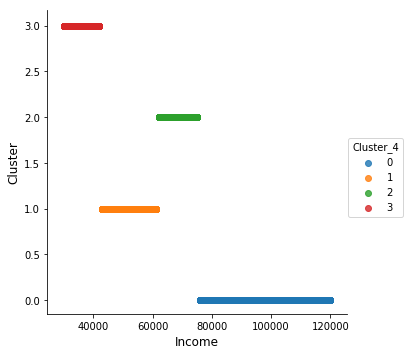

In [62]:
# Cluster and income distirbution
# You can see that this really splits the distribution of income apart
sns.lmplot(x='income', y='Cluster_4', hue='Cluster_4'
           , data=df_all_customers, fit_reg=False)
plt.xlabel('Income', fontsize = 12)
plt.ylabel('Cluster', fontsize = 12)
plt.figure(figsize=(10,8))

Earlier, we spent some time looking to see how the overall population reacted to different promotional offers. Let's now see how each cluster responds to those same promotions

In [63]:
clust_offer_aggs = pd.merge(offers_final_df, df_all_customers[['person','Cluster_4']]).groupby(
                            ['Cluster_4','offer_type','difficulty','reward']
                            , as_index = False ).agg({

     'CompletedOffer':['mean', 'sum'] # Average of time they complete the order
    , 'DaysToCompleteOffer':'mean' # Average days it takes for someone to complete the order
    , 'NetReward': 'max' # The net reward (should be just the reward - difficulty)
})

clust_offer_aggs = clust_offer_aggs[clust_offer_aggs['offer_type'] != 'informational']
clust_offer_aggs.columns.droplevel(1)
clust_offer_aggs.columns = ['Cluster_4','offer_type','difficulty','reward'
                           , 'CompletedOffers','TotalCompletions','AvgDaysToCompleteOffer','NetReward']

In [64]:
clust_offer_aggs

,Cluster_4,offer_type,difficulty,reward,CompletedOffers,TotalCompletions,AvgDaysToCompleteOffer,NetReward
0,0,bogo,5,5,0.511532,865,8.608092,0
1,0,bogo,10,10,0.526596,891,9.077441,0
2,0,discount,7,3,0.602015,478,8.924686,-4
3,0,discount,10,2,0.561009,823,8.712029,-8
4,0,discount,20,5,0.340974,238,8.394958,-15
6,1,bogo,5,5,0.329114,728,8.662088,0
7,1,bogo,10,10,0.201728,537,8.770950,0
8,1,discount,7,3,0.401826,352,8.556818,-4
9,1,discount,10,2,0.262621,489,8.527607,-8
10,1,discount,20,5,0.054434,62,12.096774,-15


In [65]:
def bogo_or_discount(row):
    """
    Checks the overall population average of completed offers for that specifc offer type
    and compares it to the cluster's completion type. Returns the promotional data type that should be offered
    if clustered average success rate is greater than average success rate within a 5% buffer
    
    INPUT - row (full row of the data frame)
    OUTPUT - string (discount or bogo)
    
    """
    offer_type = row['offer_type']
    cluster_val = row['ClusterCompletedOffers']
    avg_val = row['AvgCompletedOffers']
    
    if cluster_val + .05 > avg_val:
        return 'discount'
    else:
        return 'bogo'

Our final comparison now takes the Cluster responses to the promotions to the overal population response. If customers are much more responsive to discounted promotions, then you will want to spend more time promoting them discount offers instead of BOGO since you will continue to make more money on your promotions. If they are not responsive to discounts, BOGO will be more apropriate to get them more interested in your product and shorten their times between going to Starbucks

In [66]:
final_comparisons = pd.merge(clust_offer_aggs
         , final_overall_offers_df[['offer_type','difficulty','reward', 'CompletedOffers']]
         , how = 'inner'
         , on = ['offer_type','difficulty','reward']
        ).sort_values(['Cluster_4','offer_type','difficulty','reward'])
final_comparisons.columns = ['Cluster_4', 'offer_type', 'difficulty', 'reward', 'ClusterCompletedOffers',
       'TotalCompletions', 'AvgDaysToCompleteOffer', 'NetReward',
       'AvgCompletedOffers']

final_comparisons['BOGO_or_Discount'] = final_comparisons.apply(bogo_or_discount, axis = 1)
final_comparisons[['Cluster_4', 'offer_type', 'difficulty', 'reward'
                  , 'ClusterCompletedOffers','AvgCompletedOffers','BOGO_or_Discount']
                 ].set_index(['Cluster_4','offer_type'
                            ,'difficulty', 'reward'])

ClusterCompletedOffers  \
Cluster_4 offer_type difficulty reward                           
0         bogo       5          5                     0.511532   
                     10         10                    0.526596   
          discount   7          3                     0.602015   
                     10         2                     0.561009   
                     20         5                     0.340974   
1         bogo       5          5                     0.329114   
                     10         10                    0.201728   
          discount   7          3                     0.401826   
                     10         2                     0.262621   
                     20         5                     0.054434   
2         bogo       5          5                     0.224138   
                     10         10                    0.149921   
          discount   7          3                     0.275216   
                     10         2                     0.202934   
                     20         5                     0.048321   
3         bogo       5          5                     0.219118   
                     10         10                    0.087638   
          discount   7          3                     0.306122   
                     10         2                     0.141766   
                     20         5                     0.013237   

                                        AvgCompletedOffers BOGO_or_Discount  
Cluster_4 offer_type difficulty reward                                       
0         bogo       5          5                 0.308293         discount  
                     10         10                0.217532         discount  
          discount   7          3                 0.383878         discount  
                     10         2                 0.279512         discount  
                     20         5                 0.090034         discount  
1         bogo       5          5                 0.308293         discount  
                     10         10                0.217532         discount  
          discount   7          3                 0.383878         discount  
                     10         2                 0.279512         discount  
                     20         5                 0.090034         discount  
2         bogo       5          5                 0.308293             bogo  
                     10         10                0.217532             bogo  
          discount   7          3                 0.383878             bogo  
                     10         2                 0.279512             bogo  
                     20         5                 0.090034         discount  
3         bogo       5          5                 0.308293             bogo  
                     10         10                0.217532             bogo  
          discount   7          3                 0.383878             bogo  
                     10         2                 0.279512             bogo  
                     20         5                 0.090034             bogo

# Conclusion
These clusters seem to be apropriate for segmenting the customers. It ranges from people who have a good income and will react well to any promotion (cluster 0) all the way to people who have a smaller income and don't react better to the average customer (cluster 3).

One thing that Starbucks should stay away from is offering any kind of "Spend 20 dollars and earn 5 dollars" promotions. Especially to lower income people who take longer to respond, they should be offered BOGO's (specifically the 5 and 5 one) to get them back interested to coming back. Cluster 0 customers are having great responses to the discount promotions, almost as good as the BOGO's. So since they don't make any money back on the BOGO's, they should exclusively give them discounts to keep those customers interested and make money off the promotions as well.

We also see that most of the customers are in cluster 0, which seem to be the people who are die hard fans that will not stop at anything to get themselves some coffee. These customers are much more resilent to not needing rewards to keep them engaged, so it doesn't make sense to give them an offer that doesn't slightly benefit the company and the person at once.